In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 31.1 MB/s eta 0:00:00


In [ ]:
# ===============================
# 📦 IMPORT REQUIRED LIBRARIES
# ===============================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
import optuna
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# ===============================
# 📂 LOAD YOUR DATA
# ===============================
# Make sure your dataset (merged_df) is loaded before training
# Example:
# merged_df = pd.read_csv("your_dataset.csv")

# ===============================
# 🧩 DEFINE IMPORTANT FEATURES
# ===============================
important_features = [
    'soil_moisture', 'temperature', 'soil_humidity', 'Relative_Soil_Saturation',
    'temp_diff', 'Evapotranspiration', 'rain_vs_soil', 'rainfall', 'ph_encoded',
    'n', 'p', 'k', 'np_ratio', 'nk_ratio', 'crop_encoded', 'rain_3days',
    'moisture_temp_ratio', 'evapo_ratio', 'rain_effect', 'moisture_change_rate',
    'temp_scaled', 'npk_balance', 'wind_ratio'
]
# Load dataset from correct path
try:
    # Try different possible paths
    data_paths = [
        "../../data/Final_irregation_optimization_data.csv",  # From Smart_Irrigation_Classifier folder
        "../data/Final_irregation_optimization_data.csv",  # From models folder
        "data/Final_irregation_optimization_data.csv",  # From root
        "Final_irregation_optimization_data.csv",  # Same folder
        "/content/Final_irregation_optimization_data_m2.csv" # on google colab
    ]

    merged_df = None
    for path in data_paths:
        try:
            merged_df = pd.read_csv(path)
            print(f"✅ Data loaded successfully from: {path}")
            print(f"📊 Shape: {merged_df.shape}")
            print(f"📋 Columns: {list(merged_df.columns)}")
            break
        except FileNotFoundError:
            print(f"❌ File not found at: {path}")
            continue

    if merged_df is None:
        raise FileNotFoundError("Data file not found in any expected location!")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    exit(1)
# ===============================
# 🧠 SPLIT DATA INTO X AND y
# ===============================
X = merged_df[important_features]
y = merged_df['status']

# Fill missing values with column means
X = X.fillna(X.mean())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===============================
# 🤖 TRAIN LOGISTIC REGRESSION
# ===============================
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

print("🔹 Training Logistic Regression model...")

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.4f}")
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_lr))

# ===============================
# 🌳 TRAIN DECISION TREE MODEL
# ===============================
print("\n🔹 Training Decision Tree model...")

tree = DecisionTreeClassifier(
    max_depth=8,
    min_samples_split=4,
    random_state=42
)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

acc_tree = accuracy_score(y_test, y_pred_tree)
print(f"Decision Tree Accuracy: {acc_tree:.4f}")
print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_tree))

# ===============================
# 🐱 INITIAL CATBOOST MODEL
# ===============================
print("🔹 Training initial CatBoost model...")

cat = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.02,
    depth=10,
    l2_leaf_reg=5,
    random_strength=1.5,
    bagging_temperature=0.8,
    border_count=128,
    verbose=False,
    random_seed=42
)

cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

print(f"Initial Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")
print("\nInitial Classification Report:")
print(classification_report(y_test, y_pred_cat))

# ===============================
# 🎯 OPTUNA HYPERPARAMETER TUNING
# ===============================
print("\n🔹 Starting Optuna optimization...")

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'depth': trial.suggest_int('depth', 4, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.5, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.5, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 256),
        'verbose': False,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\n🏆 Best Parameters:", study.best_params)
print(f"🎯 Best Accuracy: {study.best_value:.4f}")

❌ File not found at: ../../data/Final_irregation_optimization_data.csv
❌ File not found at: ../data/Final_irregation_optimization_data.csv
❌ File not found at: data/Final_irregation_optimization_data.csv
❌ File not found at: Final_irregation_optimization_data.csv
✅ Data loaded successfully from: /content/Final_irregation_optimization_data_m2.csv
📊 Shape: (100000, 40)
📋 Columns: ['soil_moisture', 'temperature', 'soil_humidity', 'time', 'air_temperature_(c)', 'wind_speed_(km/h)', 'humidity', 'wind_gust_(km/h)', 'pressure_(kpa)', 'ph', 'rainfall', 'n', 'p', 'k', 'status', 'crop', 'soil_moisture_diff', 'Relative_Soil_Saturation', 'temp_diff', 'wind_effect', 'Evapotranspiration', 'rain_3days', 'rain_vs_soil', 'np_ratio', 'nk_ratio', 'ph_category', 'ph_encoded', 'crop_encoded', 'moisture_temp_ratio', 'evapo_ratio', 'rain_effect', 'moisture_change_rate', 'temp_scaled', 'npk_balance', 'wind_ratio', 'recommended_water_mm', 'soil_moisture_updated', 'recommended_N', 'recommended_P', 'recommended_

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6963

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.70      0.61      0.65      9305
           1       0.69      0.77      0.73     10695

    accuracy                           0.70     20000
   macro avg       0.70      0.69      0.69     20000
weighted avg       0.70      0.70      0.69     20000


🔹 Training Decision Tree model...
Decision Tree Accuracy: 0.7504

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.75      0.69      0.72      9305
           1       0.75      0.80      0.78     10695

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

🔹 Training initial CatBoost model...


[I 2025-11-25 17:42:53,335] A new study created in memory with name: no-name-82a4730b-6643-4b24-8aa6-6a592dddcbea


Initial Accuracy: 0.8471

Initial Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      9305
           1       0.84      0.88      0.86     10695

    accuracy                           0.85     20000
   macro avg       0.85      0.84      0.85     20000
weighted avg       0.85      0.85      0.85     20000


🔹 Starting Optuna optimization...


[I 2025-11-25 17:43:25,688] Trial 0 finished with value: 0.8016 and parameters: {'iterations': 1173, 'learning_rate': 0.012558429258507567, 'depth': 8, 'l2_leaf_reg': 8.137204682274874, 'random_strength': 0.5578686384117097, 'bagging_temperature': 0.5559200393763939, 'border_count': 45}. Best is trial 0 with value: 0.8016.
[I 2025-11-25 17:45:26,336] Trial 1 finished with value: 0.82975 and parameters: {'iterations': 757, 'learning_rate': 0.01496833524965832, 'depth': 12, 'l2_leaf_reg': 5.7453588158183475, 'random_strength': 1.5696906738998522, 'bagging_temperature': 0.9508501847761559, 'border_count': 110}. Best is trial 1 with value: 0.82975.
[I 2025-11-25 17:52:52,323] Trial 2 finished with value: 0.87135 and parameters: {'iterations': 2216, 'learning_rate': 0.04316994931452033, 'depth': 12, 'l2_leaf_reg': 9.061117896474622, 'random_strength': 1.1296355734066383, 'bagging_temperature': 0.5868360762286051, 'border_count': 170}. Best is trial 2 with value: 0.87135.
[I 2025-11-25 18:02

In [12]:
# ===============================
# 🚀 TRAIN FINAL MODEL WITH BEST PARAMS
# ===============================
best_params = study.best_params
best_params['verbose'] = False
best_params['random_seed'] = 42

print("\n🔹 Training final CatBoost model with best parameters...")
best_cat = CatBoostClassifier(**best_params)
best_cat.fit(X_train, y_train)

# ===============================
# 📊 EVALUATE FINAL MODEL
# ===============================
y_pred = best_cat.predict(X_test)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

print(f"\n✅ Final Accuracy: {acc:.4f}")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred))


🔹 Training final CatBoost model with best parameters...

✅ Final Accuracy: 0.8734

Final Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      9305
           1       0.87      0.90      0.88     10695

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000




📊 Generating accuracy comparison chart...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


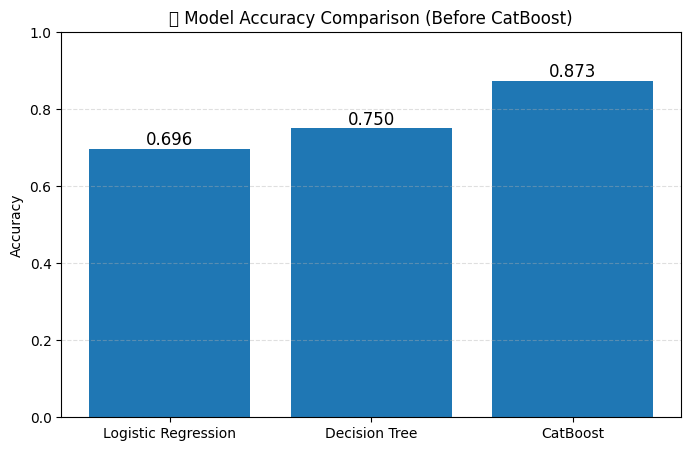

In [10]:
# =======================================
# 📊 VISUALIZE ACCURACY COMPARISON
# =======================================
print("\n📊 Generating accuracy comparison chart...")

model_names = ["Logistic Regression", "Decision Tree", "CatBoost"]
accuracies = [acc_lr, acc_tree, acc ]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies)

# Add accuracy labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + 0.01,
             f"{height:.3f}",
             ha='center', fontsize=12)

plt.title("🔍 Model Accuracy Comparison (Before CatBoost)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()



In [13]:
# ===============================
# 🌟 FEATURE IMPORTANCE
# ===============================
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_cat.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# ===============================
# 💾 SAVE RESULTS AND MODEL
# ===============================
#report_df = pd.DataFrame(report).transpose()
#report_df.to_csv("model_report.csv", index=True)

#with open("model_accuracy.txt", "w") as f:
#    f.write(f"Final Accuracy: {acc:.4f}\n")

# Save trained model
#joblib.dump(best_cat, "catboost_model.pkl")

#print("\n✅ Model and reports saved successfully!")
#print("📁 Files created: model_report.csv, model_accuracy.txt, catboost_model.pkl")



Top 10 Important Features:
                Feature  Importance
2         soil_humidity   13.987898
0         soil_moisture    8.554175
1           temperature    6.989884
10                    p    6.562794
11                    k    5.778494
7              rainfall    5.319566
16  moisture_temp_ratio    5.212689
8            ph_encoded    5.108770
22           wind_ratio    5.047276
9                     n    4.467239
